<a href="https://colab.research.google.com/github/anubhavshrestha/Machine-Learning/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import cv2## image processing
import os## operating system
import random
import copy
from google.colab import files
import torch, torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anubhavshresthax","key":"9e69bc28da132f9241cf33f835662d15"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 95% 293M/309M [00:01<00:00, 250MB/s]
100% 309M/309M [00:01<00:00, 253MB/s]


In [7]:
!unzip /content/human-emotions-datasethes.zip

Streaming output truncated to the last 5000 lines.
  inflating: EmotionsDataset/data/nothing/720.jpg  
  inflating: EmotionsDataset/data/nothing/721.jpg  
  inflating: EmotionsDataset/data/nothing/722.jpg  
  inflating: EmotionsDataset/data/nothing/723.jpg  
  inflating: EmotionsDataset/data/nothing/724.jpg  
  inflating: EmotionsDataset/data/nothing/725.jpg  
  inflating: EmotionsDataset/data/nothing/726.jpg  
  inflating: EmotionsDataset/data/nothing/727.jpg  
  inflating: EmotionsDataset/data/nothing/728.jpg  
  inflating: EmotionsDataset/data/nothing/729.jpg  
  inflating: EmotionsDataset/data/nothing/73.jpg  
  inflating: EmotionsDataset/data/nothing/730.jpg  
  inflating: EmotionsDataset/data/nothing/731.jpg  
  inflating: EmotionsDataset/data/nothing/732.jpg  
  inflating: EmotionsDataset/data/nothing/733.jpg  
  inflating: EmotionsDataset/data/nothing/734.jpg  
  inflating: EmotionsDataset/data/nothing/735.jpg  
  inflating: EmotionsDataset/data/nothing/736.jpg  
  inflating: E

In [8]:
train_directory = "Emotions Dataset/Emotions Dataset/train/"
test_directory = "Emotions Dataset/Emotions Dataset/test/"


train_list_angry_paths = []
train_list_sad_paths = []
train_list_happy_paths = []


train_list_angry_paths += os.listdir(str(train_directory)+ "angry/")
train_list_sad_paths += os.listdir(str(train_directory)+ "sad/")
train_list_happy_paths += os.listdir(str(train_directory)+ "happy/")

train_list_angry_paths = [str(train_directory+"angry/") + i for i in train_list_angry_paths]
train_list_happy_paths = [str(train_directory+ "happy/") + i for i in train_list_happy_paths]
train_list_sad_paths = [str(train_directory+ "sad/") + i for i in train_list_sad_paths]


train_data_path = train_list_happy_paths + train_list_angry_paths + train_list_sad_paths
random.shuffle(train_data_path)

test_list_angry_paths = []
test_list_sad_paths = []
test_list_happy_paths = []

test_list_angry_paths += os.listdir(str(test_directory)+ "angry/")
test_list_sad_paths += os.listdir(str(test_directory)+ "sad/")
test_list_happy_paths += os.listdir(str(test_directory)+ "happy/")

test_list_angry_paths = [str(test_directory+"angry/") + i for i in test_list_angry_paths]
test_list_happy_paths = [str(test_directory + "happy/") +i for i in test_list_happy_paths]
test_list_sad_paths = [str(test_directory+ "sad/") + i for i in test_list_sad_paths]



val_ratio = 0.5
val_list_angry_paths = test_list_angry_paths[0:int(len(test_list_angry_paths) * val_ratio)]
test_list_angry_paths = test_list_angry_paths[int(len(test_list_angry_paths) * val_ratio):]

val_list_sad_paths = test_list_sad_paths[0:int(len(test_list_sad_paths) * val_ratio)]
test_list_sad_paths = test_list_sad_paths[int(len(test_list_sad_paths) * val_ratio):]

val_list_happy_paths = test_list_happy_paths[0:int(len(test_list_happy_paths) * val_ratio)]
test_list_happy_paths = test_list_happy_paths[int(len(test_list_happy_paths) * val_ratio):]


test_data_path = test_list_angry_paths + test_list_sad_paths + test_list_happy_paths
random.shuffle(test_data_path)

val_data_path = val_list_angry_paths+val_list_happy_paths + val_list_sad_paths
random.shuffle(val_data_path)

train_paths = train_data_path
test_paths = test_data_path
val_paths = val_data_path


In [9]:
class HumanEmotions(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])

    if(self.image_filepaths[index].split('/')[3] == 'happy'):
      label = 2.0
    elif((self.image_filepaths[index].split('/')[3] == 'angry')):
      label = 1.0
    else:
      label = 0.0

    if self.transform:
      image = self.transform(image = image)['image']

    return image, label

Emotions Dataset/Emotions Dataset/train/happy/999578.jpg


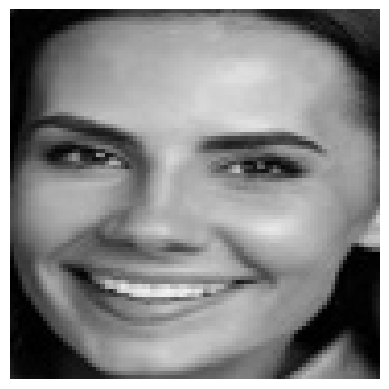

In [10]:
random_index = random.randint(1, 1000)
print(train_paths[random_index])

img_color = cv2.imread(train_paths[random_index], 1)

if img_color is None:
    print("Error: Image not loaded. Check the file path or file format.")
else:
    plt.imshow(img_color)
    plt.axis("off")
    plt.show()

In [11]:
IM_SIZE = 224
transform = A.Compose([
                        A.Resize(IM_SIZE, IM_SIZE),
                        A.RandomBrightnessContrast(brightness_limit=0.2,
                                                  contrast_limit=0.2,
                                                  always_apply=False, p=0.5),
                        A.Normalize(),
])

In [12]:
train_dataset = HumanEmotions(train_paths, transform)
val_dataset = HumanEmotions(val_paths, transform)
test_dataset = HumanEmotions(test_paths, transform)
print(train_dataset[1])
print()
print(val_dataset[1])
print()
print(test_dataset[1])

(array([[[-1.7240345 , -1.6330531 , -1.4035729 ],
        [-1.6897851 , -1.5980392 , -1.3687146 ],
        [-1.6726604 , -1.5805321 , -1.3512853 ],
        ...,
        [-0.30268008, -0.17997196,  0.04305013],
        [-0.57667613, -0.460084  , -0.23581697],
        [-0.57667613, -0.460084  , -0.23581697]],

       [[-1.7411593 , -1.6505601 , -1.4210021 ],
        [-1.7240345 , -1.6330531 , -1.4035729 ],
        [-1.6897851 , -1.5980392 , -1.3687146 ],
        ...,
        [-0.23418106, -0.10994395,  0.11276691],
        [-0.54242665, -0.42507   , -0.20095858],
        [-0.55955136, -0.44257697, -0.21838777]],

       [[-1.7754089 , -1.685574  , -1.4558605 ],
        [-1.7582841 , -1.6680671 , -1.4384313 ],
        [-1.7240345 , -1.6330531 , -1.4035729 ],
        ...,
        [-0.64517516, -0.53011197, -0.30553374],
        [-0.9191712 , -0.810224  , -0.58440083],
        [-0.9534207 , -0.84523803, -0.61925924]],

       ...,

       [[-1.6897851 , -1.5980392 , -1.3687146 ],
        [-

In [13]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

print(len(train_loader))

213


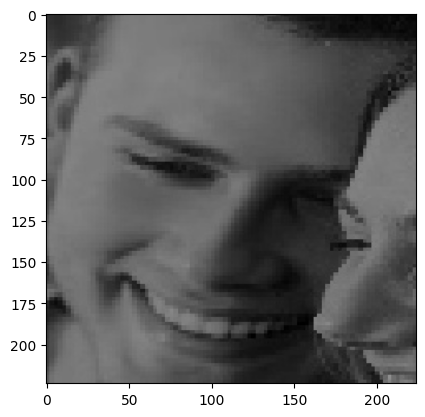

In [14]:
imagex = cv2.imread(train_paths[0])
plt.imshow(imagex)

plt.show()

In [15]:
image, label = next(iter(train_loader))

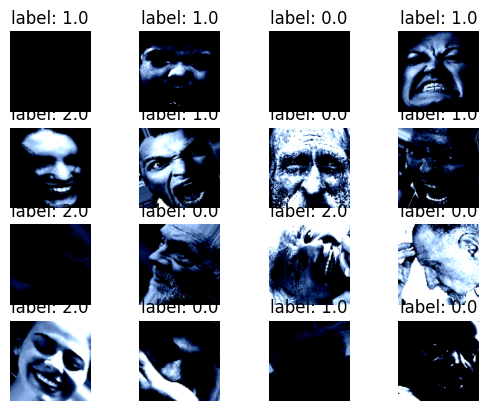

In [16]:
for i, (image, label) in enumerate(train_loader):
    ax = plt.subplot(4, 4, i + 1)

    # Assuming the batch size is 16 (4x4 grid), access each image in the batch:
    plt.imshow(image[0])  # Assuming you want to display the first image in each batch

    plt.title('label: {}'.format(label[0]))  # Assuming you want to display the label of the first image
    plt.axis('off')

    if i == 15:  # Assuming you only want to display the first 16 images (4x4 grid)
        break

plt.show()

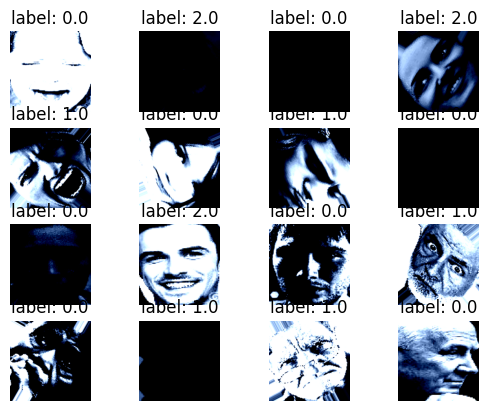

In [17]:
image, label = next(iter(val_loader))
for i, (image, label) in enumerate(val_loader):
    ax = plt.subplot(4, 4, i + 1)

    # Assuming the batch size is 16 (4x4 grid), access each image in the batch:
    plt.imshow(image[0])  # Assuming you want to display the first image in each batch

    plt.title('label: {}'.format(label[0]))  # Assuming you want to display the label of the first image
    plt.axis('off')

    if i == 15:  # Assuming you only want to display the first 16 images (4x4 grid)
        break

plt.show()

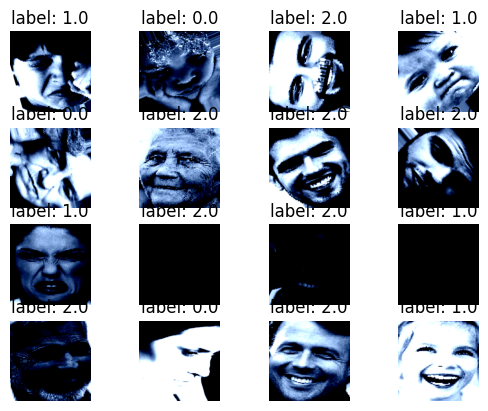

In [18]:
image, label = next(iter(test_loader))
for i, (image, label) in enumerate(test_loader):
    ax = plt.subplot(4, 4, i + 1)

    # Assuming the batch size is 16 (4x4 grid), access each image in the batch:
    plt.imshow(image[0])  # Assuming you want to display the first image in each batch

    plt.title('label: {}'.format(label[0]))  # Assuming you want to display the label of the first image
    plt.axis('off')

    if i == 15:  # Assuming you only want to display the first 16 images (4x4 grid)
        break

plt.show()

In [19]:
image, label = next(iter(train_loader))

In [20]:
device = "cuda"
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        P = 1
        S = 1
        F = 5


        #initial calculation for what the H and W that go inside the first linear layer will be
        H, W, C = image[0].shape

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=C, out_channels=16, kernel_size=F, stride=S, padding=P, device = device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # after first conv:
        H = int((H + 2 * P -F) / S) + 1
        W = int((W + 2 * P- F) / S) + 1

        #after first pooling
        H = H//2
        W = W//2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1, device = device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )
         # after second conv:
        H = int((H + 2 * P - (F - 1) - 1) / S) + 1
        W = int((W + 2 * P- (F - 1) - 1) / S) + 1

        #after second pooling
        H = H//2
        W = W//2

        # Define fully connected layers
        self.fc1 = nn.Linear(32 * H * W, 1000, device = device)  # Assuming H and W are 56 after two max-pooling layers
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 100, device = device)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100, 3, device = device)
        self.softmax = nn.Softmax()

    def forward(self, x):
        # First Convolutional Block
        x = self.conv_block1(x)

        # Second Convolutional Block
        x = self.conv_block2(x)

        # Flatten
        x = x.reshape((x.shape[0], -1))  # Reshape to (batch_size, 32 * H * W) #flattening


        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

# Create an instance of your model
model = CNN_model()
print(model)

CNN_model(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=93312, out_features=1000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)


In [37]:
def get_summary_writer(model_name):
    log_dir = f"runs/{model_name}"
    return SummaryWriter(log_dir=log_dir)

#Training using own function
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter

losses = []
val_losses = []
# Define the training function
def train(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    patience = 3 #for early stopping
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_correct = 0
        total_samples = 0
        for batch_data, batch_labels in train_loader:
            optimizer.zero_grad()
            batch_data, batch_labels = batch_data.permute(0, 3, 1, 2).to(device).float(), batch_labels.to(device).long()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total_samples += batch_labels.size(0)
            total_correct += (predicted == batch_labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = 100.0 * total_correct / total_samples
        losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
              batch_data, batch_labels = batch_data.permute(0, 3, 1, 2).to(device).float(), batch_labels.to(device).long()
              outputs = model(batch_data)
              loss = criterion(outputs, batch_labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs, 1)
              total_samples += batch_labels.size(0)
              total_correct += (predicted == batch_labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * total_correct / total_samples
        val_losses.append(val_loss)

        # Print progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
            break


In [38]:
losses = []
val_losses = []
train(model, train_loader, val_loader, 10, 1e-4)

<ipython-input-20-6f696b6e6eb6>:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Epoch 1/10, Train Loss: 1.0088, Val Loss: 0.9933, Train Accuracy: 52.38%, Val Accuracy: 55.36%
Epoch 2/10, Train Loss: 0.9338, Val Loss: 0.9146, Train Accuracy: 60.82%, Val Accuracy: 62.48%
Epoch 3/10, Train Loss: 0.8616, Val Loss: 0.8990, Train Accuracy: 68.52%, Val Accuracy: 65.20%
Epoch 4/10, Train Loss: 0.8082, Val Loss: 0.8996, Train Accuracy: 74.44%, Val Accuracy: 65.11%
Epoch 5/10, Train Loss: 0.7811, Val Loss: 0.8505, Train Accuracy: 77.14%, Val Accuracy: 69.24%
Epoch 6/10, Train Loss: 0.7475, Val Loss: 0.8340, Train Accuracy: 80.48%, Val Accuracy: 71.27%
Epoch 7/10, Train Loss: 0.7175, Val Loss: 0.8359, Train Accuracy: 83.85%, Val Accuracy: 70.65%
Epoch 8/10, Train Loss: 0.6983, Val Loss: 0.8272, Train Accuracy: 85.54%, Val Accuracy: 72.41%
Epoch 9/10, Train Loss: 0.6814, Val Loss: 0.8185, Train Accuracy: 87.23%, Val Accuracy: 73.11%
Epoch 10/10, Train Loss: 0.6722, Val Loss: 0.8483, Train Accuracy: 88.28%, Val Accuracy: 69.95%


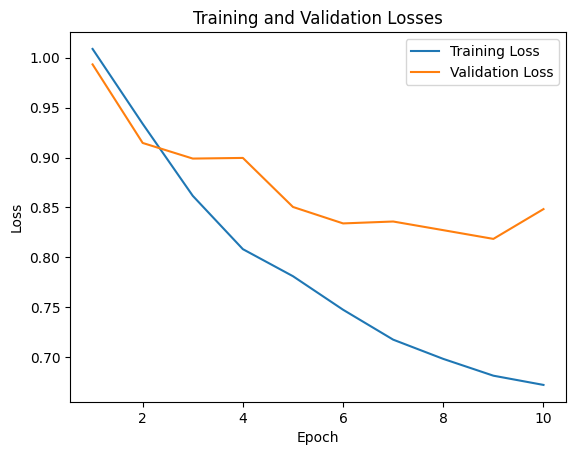

In [39]:
training_epoch = 10
# Plotting the losses and validation losses
plt.plot(range(1, training_epoch+1), losses, label="Training Loss")
plt.plot(range(1, training_epoch+1), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [44]:
def test(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.permute(0, 3, 1, 2).to(device).float(), batch_labels.to(device).long()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += batch_labels.size(0)
            total_correct += (predicted == batch_labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * total_correct / total_samples

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [45]:
test(model, test_loader)

<ipython-input-20-6f696b6e6eb6>:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Test Loss: 0.8385, Test Accuracy: 70.26%


In [48]:

def round(x):
  _, max_arg = torch.max(x, dim = 1)

  if max_arg == 0:
    return "Sad"
  elif max_arg == 1:
    return "Angry"
  elif max_arg ==2:
    return "Happy"

In [62]:
#predicting output of one data:
def predict(x,model = model, new_image = False): #new image are those images that do not require permutations
  model.eval()

  if len(x.shape) == 3:
    x = x.unsqueeze(0)
  if not new_image:
    x = x.permute(0, 3, 1, 2)

  x = x.to(device)

  pred = model(x)
  return round(pred)


<ipython-input-20-6f696b6e6eb6>:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


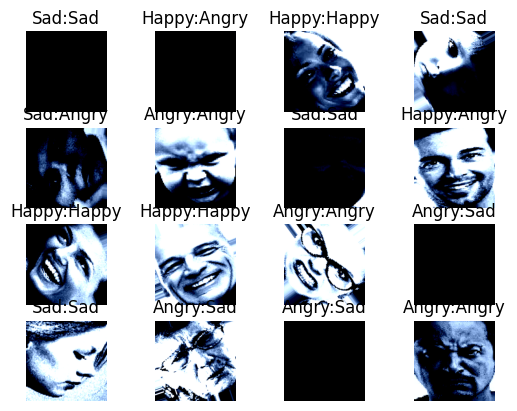

In [63]:
#visualizing the results
count = 0
for i, (image, label) in enumerate(test_loader):
  if count == 16:
    break
  count+= 1
  random_int = random.randint(0, BATCH_SIZE-1)
  random_image_from_batch = image[random_int]
  label = label[random_int]
  if label ==0:
    correct_answer = "Sad"
  elif label == 1:
    correct_answer = "Angry"
  else:
    correct_answer = "Happy"
  model.eval()
  model_answer = predict(random_image_from_batch)
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(random_image_from_batch)
  plt.title(str(correct_answer) + ":" + str(model_answer))
  plt.axis("off")


Mounted at /content/drive


<ipython-input-20-6f696b6e6eb6>:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


'Happy'

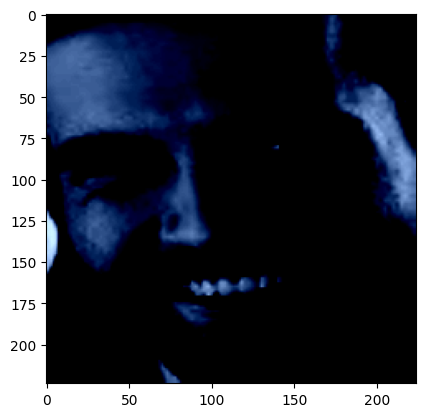

In [51]:
from google.colab import drive
drive.mount('/content/drive')
#predicting images
for image, label in test_loader:
  img, lb = image[1], label[1]
  break

plt.imshow(img)
predict(img)


In [52]:
save_path = "/content/drive/My Drive/Colab Notebooks/model_human_emotions.pt"
# Save the model checkpoint
torch.save(model.state_dict(), save_path)

Saving 109046.jpg_brightness_2.jpg to 109046.jpg_brightness_2 (1).jpg
The object in the image is:  Sad


<ipython-input-20-6f696b6e6eb6>:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


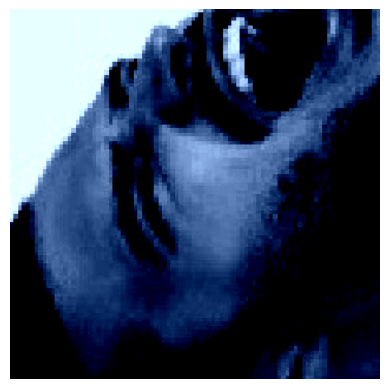

In [64]:
#upload an image and predict using this model
from PIL import Image
import albumentations as A
import io

IM_SIZE = 224
transform = A.Compose([
                        A.Resize(IM_SIZE, IM_SIZE),
                        A.RandomRotate90(),
                        A.RandomBrightnessContrast(brightness_limit=0.2,
                                                  contrast_limit=0.2,
                                                  always_apply=False, p=0.5),

                        A.OneOf([A.HorizontalFlip(),
                                 A.VerticalFlip(),], p = 0.3), #so that all data are either flipped left or right, to make
                        #data independent of orientation
                        A.Normalize()
                       #normalizes the data
])

# Function to predict the class of an uploaded image
def predict_image(image_content, model, transform, device):
    # Load the image
    image = Image.open(io.BytesIO(image_content)).convert('RGB') #converting the image_content to RGB mode agter opening it using Python Image Library(PIL)

    # Apply albumentations transformations
    augmented = transform(image=np.array(image))
    input_image = augmented['image']
    input_tensor = torch.tensor(input_image, dtype=torch.float).unsqueeze(0).to(device).permute(0, 3, 1,2) #unsqueeze add another dimension accordingly



    pred = predict(input_tensor, new_image = True)

    input_tensor_cpu = input_tensor.cpu()
    augmented_image = input_tensor_cpu.squeeze(0).numpy()


    return pred, augmented_image



# Upload a file and store it in the current working directory of Colab
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Get the uploaded file's name
image_content = uploaded[file_name]    # Get the content of the uploaded file as bytes

# Assuming you have a device (CPU or GPU) defined earlier, use it here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make a prediction on the uploaded image
pred, augmented_image = predict_image(image_content, model, transform, device)

# Print or display the prediction result
print("The object in the image is: ", pred)

# Transpose the augmented_image to the format (height, width, channels)
augmented_image = augmented_image.transpose(1, 2, 0) #changing from 3, 224, 224 to 224, 224, 3 which plt expects us to do

# Clip the values to be within [0, 1] in case of normalization
augmented_image = np.clip(augmented_image, 0, 1)

# Display the augmented image using plt.imshow()
plt.imshow(augmented_image)
plt.axis('off')  # Turn off axis labels
plt.show()



In [55]:
pre_resnet18 = models.resnet18(pretrained=True)
num_ftrs = pre_resnet18.fc.in_features
pre_resnet18.fc = nn.Linear(num_ftrs,3)
print(pre_resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
losses = []
val_losses = []
train(pre_resnet18, train_loader, val_loader, 10, 1e-4)

Epoch 1/10, Train Loss: 0.5684, Val Loss: 0.4154, Train Accuracy: 76.39%, Val Accuracy: 83.66%
Epoch 2/10, Train Loss: 0.2626, Val Loss: 0.3888, Train Accuracy: 89.98%, Val Accuracy: 86.12%
Epoch 3/10, Train Loss: 0.1734, Val Loss: 0.4257, Train Accuracy: 93.91%, Val Accuracy: 86.29%
Epoch 4/10, Train Loss: 0.1162, Val Loss: 0.4084, Train Accuracy: 95.87%, Val Accuracy: 86.73%
Epoch 5/10, Train Loss: 0.0930, Val Loss: 0.4438, Train Accuracy: 96.32%, Val Accuracy: 86.64%
Early stopping at epoch 5. Best validation loss: 0.3888


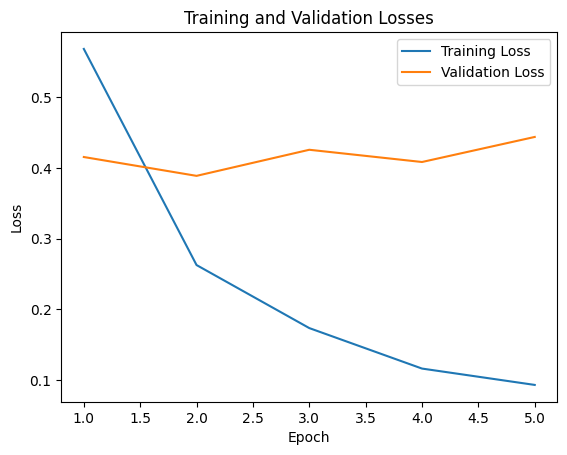

In [57]:

training_stopped_epoch = 5
# Plotting the losses and validation losses
plt.plot(range(1, training_stopped_epoch+1), losses, label="Training Loss")
plt.plot(range(1, training_stopped_epoch+1), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [58]:
test(pre_resnet18, test_loader)

Test Loss: 0.4746, Test Accuracy: 85.88%


In [59]:
save_path = "/content/drive/My Drive/Colab Notebooks/pre_resnet18_human_emotions.pt"
# Save the model checkpoint
torch.save(model.state_dict(), save_path)

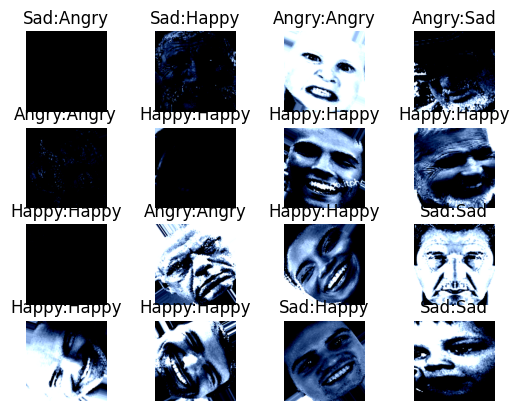

In [66]:
count = 0
for i, (image, label) in enumerate(test_loader):
  if count == 16:
    break
  count+= 1
  random_int = random.randint(0, BATCH_SIZE-1)
  random_image_from_batch = image[random_int]
  label = label[random_int]
  if label ==0:
    correct_answer = "Sad"
  elif label == 1:
    correct_answer = "Angry"
  else:
    correct_answer = "Happy"
  model.eval()
  model_answer = predict(random_image_from_batch, model = pre_resnet18)
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(random_image_from_batch)
  plt.title(str(correct_answer) + ":" + str(model_answer))
  plt.axis("off")


In [69]:
#making a Confusion Matrix for test predictions
from sklearn.metrics import confusion_matrix


pre_resnet18.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for m in test_loader:
        test_x = m[0].to(device).permute(0, 3, 1, 2)
        test_y = m[1].to(device)


        test_pred = pre_resnet18(test_x)

        # Get the predicted class by taking the index of the maximum value in each prediction
        _, predicted_class = torch.max(test_pred, dim=1)

        all_predictions.extend(predicted_class.tolist())
        all_targets.extend(test_y.tolist())

# Convert lists to torch tensors
all_predictions = torch.tensor(all_predictions)
all_targets = torch.tensor(all_targets)

# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
print("Total data = ", len(test_loader)* 32)

Confusion Matrix:
[[331  17  31]
 [ 38 204  16]
 [ 35  20 448]]
Total data =  1152
